In [214]:
!git add Parser.ipynb
!git commit -m "map objects function ready"
!git push

[master 627d29d] map objects function ready
 1 file changed, 308 insertions(+), 65 deletions(-)
Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (5/5), 10.26 KiB | 0 bytes/s, done.
Total 5 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/DmitrySerg/OpenData
   a7fca36..627d29d  master -> master


## Цель
- Собрать базу открытых данных с сайта Московской патриархии о персоналиях, организациях, богослужебных указаниях и храмах, структурировать их и загрузить в хаб открытых данных

## Задача
- проинвентаризировать данные на сайте Московской патриархии
- написать парсеры и выгрузить данные в форматах CSV и JSON
- загрузить данные в хаб открытых данных http://hubofdata.ru в удобном виде.
## Требования
- открытый исходный код в Github под свободной лицензией
- межплатформенный код (возможность запуска на Linux/Windows)
- предусмотреть перенос всех метаданных в CKAN в виде тегов и атрибутов
- переносить все данные в CKAN или на отдельный хостинг (например, в Github)
## Данные
- Персоналии - http://www.patriarchia.ru/db/persons/
- Организации - http://www.patriarchia.ru/db/organizations/
- Богослужебные указания - http://www.patriarchia.ru/bu/
- Храмы - http://map.patriarhia.ru/
## Пожелания
- реализация в виде программы командной строки или веб-приложения
- возможность запуска на MacOSX
- использовать скриптовые языки такие как Python, Perl, R и другие.

In [1]:
import requests      
import numpy as np   
import pandas as pd  
import time          
from bs4 import BeautifulSoup

import os
import json
import string

from tqdm import tqdm_notebook

In [215]:
main_link = "http://www.patriarchia.ru"
link_persons = "http://www.patriarchia.ru/db/persons/"
link_organizations = "http://www.patriarchia.ru/db/organizations/"
link_guidance = "http://www.patriarchia.ru/bu/"
link_churches = "http://map.patriarhia.ru/"
link_map_objects = 'http://map.patriarhia.ru/api/index.php?token=c2cbe8cd873f8e4751a7f7bb5292e68a&s=&params=[]&_=1530217371426'

file_path = os.getcwd() + "/data/{}"

In [3]:
class Parser:
    
    def __init__(self):
        pass
    
    def getSoup(self, link):
        """
            Returns bs4-formatted page
        """
        html = requests.get(link)
        if html.status_code == 200:
            soup = BeautifulSoup(html.content, 'lxml')
        else:
            soup = None
        return soup
    
    def getAllLinks(self, dataset_type, url=None):
        """
            Returns a list with names, links and affiliations for persons and organizations;
            dates for guidance or map objects

            dataset_type: string
                persons/organizations/guidance/map
                
            url: string
                url to parse data from
        """
        
        if dataset_type=='guidance':
            datelist = pd.date_range(
                pd.to_datetime(start_date), end=pd.to_datetime(end_date)
            ).tolist()
            datelist = [date.strftime("%Y-%m-%d") for date in datelist]
            return datelist
        
        if dataset_type=='map':
            map_objects = requests.get(link_map_objects)
            map_objects = map_objects.content
            map_objects = json.loads(map_objects)['features']
            return map_objects

        links = getSoup(url)
        links = links.find('div', attrs={"class":"main"})
        links = links.findAll('div', attrs={'class':'news'})

        dfLinks = []
        for link in links:
            name = link.find('h4').text
            linkParsed = main_link + link.find('a')['href']
            affiliation = link.find('div').text
            dfLinks.append({"name":name, "link":linkParsed, "affiliation":affiliation})

        return dfLinks

    def getPageData(link):
        """
            Returns a dict with parsed field:value pairs from page

            link: string
                link to page
        """

        data = {}

        # use printing version of page 
        link = link.replace("text", "print")

        # first - get the page content
        pageContent = getSoup(link)

        # trying to find any images
        try:
            image_link = pageContent.find('div', attrs={'class':'news_img'})
            image_link = image_link.find('img')['src']
            data.update({'image_link':image_link})
        except:
            pass

        # now concentrate on text
        pageContent = pageContent.find('div', attrs={'class':'main'})
        pageContent = pageContent.findAll("dl")

        # second - find all field-value pairs on page
        for text in pageContent:        
            number_of_fields = len(text.findAll('dt'))*2-1
            if number_of_fields>0:
                parsedFields = []
                currentValue = text.find('dt')
                parsedFields.append(' '.join(currentValue.findAll(text=True)).strip().replace(u'\xa0', u' '))

                while number_of_fields>0:
                    currentValue = currentValue.nextSibling
                    if currentValue != '\n':
                        value = ' '.join(currentValue.findAll(text=True)).strip().replace(u'\xa0', u' ')
                        if value:
                            parsedFields.append(value)
                            number_of_fields -= 1

                text = dict(zip(parsedFields[::2], parsedFields[1::2]))
                data.update(text)

        return data
    
    def getGuidanceData(date):
        """
            Returns dict with name:text pair for particular day
        """
        link = link_guidance + date + '/print.html'
        pageContent = getSoup(link)
        pageContent = pageContent.find('div', attrs={'class':'main'})
        pageContent = pageContent.findAll('p')

        name = pageContent[0].getText().strip()
        pageContent = [paragraph.getText() for paragraph in pageContent[1:]]
        text = "\n".join(pageContent)
        data = {'date':date, 'name':name, 'text':text}

        return data
    
    def getMapObjectData(current_object):
        """
            Parse data of a map object, return dict with values

            current_object: bs4.element.Tag
                bs4 object from map
        """
        data = {}

        # parsing map info
        infoid = current_object['id']
        lat, long = current_object['geometry']['coordinates']
        name = current_object['properties']['hintContent']

        # moving to object page
        current_link = 'http://map.patriarhia.ru/?infoid={}'.format(infoid)
        data.update({"link":current_link, "lat":lat, "long":long, "name":name})
        current_object = getSoup(current_link)
        current_object = current_object.find('div', attrs={'class':'main'})

        # address
        address = current_object.find('dl', attrs={'class':'addr'})
        if address:
            data.update({'address':address.getText()})

        # contact info
        contacts = current_object.find("div", attrs={'class':"reg-info-contact"}).findAll('dl')
        contacts = contacts[0].findAll('dd')
        for current_contact in contacts:
            contact_type = current_contact.find('span').get('class')[0]
            contact_value = current_contact.getText()
            data.update({contact_type:contact_value})

        # dependent structure info
        structures = current_object.find('div', attrs={'id':'parent_site_list'})
        if structures:
            structures = structures.findAll('h1')
            structures = ', '.join([structure.getText().strip() for structure in structures])
            data.update({'structure':structures})

        return data
    
    def saveDataFrame(self, final, dataset_type):
        """
            Save final file into csv and json files
            
            final: list
                parsed data from pages
                
            dataset_type: string
                persons or organizations
        """
        
        df = pd.DataFrame(final)
        df.columns = df.columns.str.strip(':')
        
        if dataset_type=="persons":
            csv_path = file_path.format("persons.csv")
            json_path = file_path.format("persons.json")
            column_names = ['name','affiliation','Страна','Дата рождения', 
                           'Дата пострига','Дата хиротонии', 'Дата смерти',
                           'День ангела', 'Епархия', 'Место работы', 'Образование', 
                           'Биография', 'Награды', 'Научные труды, публикации', 
                           'E-mail', 'Web-сайт', 'link', 'image_link']
            df = df[column_names]
        elif dataset_type=="organizations":
            csv_path = file_path.format("organizations.csv")
            json_path = file_path.format("organizations.json")
        elif dataset_type=="map":
            csv_path = file_path.format("map_objects.csv")
            json_path = file_path.format("map_objects.json")
        else:
            csv_path = file_path.format("guidance.csv")
            json_path = file_path.format("guidance.json")
        
        df.to_csv(csv_path, encoding='utf8')
        df.to_json(json_path)
            
    def runCrawler(self, links_data, dataset_type='other'):
        """
            Iterate over all links in links_data and return final dataset
            
            links_data: list
                list with links to pages
            
            dataset_type: string
                guidance/map or other
        """
        final = []

        for page in tqdm_notebook(links_data):
            try:
                if dataset_type=='guidance':
                    currentDateData = self.getGuidanceData(page)
                    final.append(currentDateData)
                elif dataset_type=='map':
                    object_data = getMapObjectData(page)
                    final.append(object_data)
                else:
                    data = self.getPageData(page['link'])
                    page.update(data)
                    final.append(page)
                time.sleep(0.5)
            except Exception as e:
                # print(e)                           # DEBUG
                # print('problem',  page['link'])  # DEBUG
                time.sleep(30)
                
        return final
        
    
    def runParsing(self, dataset_type):
        
        if dataset_type=='persons':
            link = link_persons
        elif dataset_type=='organizations':
            link = link_organizations
        else:
            pass
        
        allLinks = self.getAllLinks(dataset_type, link)
        data = self.runCrawler(allLinks, dataset_type)
        self.saveDataFrame(data, dataset_type)

In [451]:
parser = Parser()
parser.runParsing('persons')
parser.runParsing('organizations')
parser.runParsing('guidance')
parser.runParsing('map')

In [4]:
def getSoup(link):
    """
        Returns bs4-formatted page
    """
    html = requests.get(link)
    if html.status_code == 200:
        soup = BeautifulSoup(html.content, 'lxml')
    else:
        soup = None
    return soup

def getAllLinks(url):
    """
        Returns a list with names, links and affiliations    
        
        url: string
            url to parse data from
    """
    
    links = getSoup(url)
    links = links.find('div', attrs={"class":"main"})
    links = links.findAll('div', attrs={'class':'news'})
    
    dfLinks = []
    for link in links:
        name = link.find('h4').text
        linkParsed = main_link + link.find('a')['href']
        affiliation = link.find('div').text
        dfLinks.append({"name":name, "link":linkParsed, "affiliation":affiliation})
        
    return dfLinks

def getPageData(link):
    """
        Returns a dict with parsed field:value pairs from page
    
        link: string
            link to page
    """
    
    data = {}
    
    # use printing version of page 
    if 'text' in link:
        link = link.replace("text", "print")
    
    # first - get the page content
    pageContent = getSoup(link)
    
    # trying to find any images
    try:
        image_link = pageContent.find('div', attrs={'class':'news_img'})
        image_link = image_link.find('img')['src']
        data.update({'image_link':image_link})
    except:
        pass
    
    # now concentrate on text
    pageContent = pageContent.find('div', attrs={'class':'main'})
    pageContent = pageContent.findAll("dl")

    # second - find all field-value pairs on page
    for text in pageContent:        
        number_of_fields = len(text.findAll('dt'))*2-1
        if number_of_fields>0:
            parsedFields = []
            currentValue = text.find('dt')
            parsedFields.append(' '.join(currentValue.findAll(text=True)).strip().replace(u'\xa0', u' '))

            while number_of_fields>0:
                currentValue = currentValue.nextSibling
                if currentValue != '\n':
                    value = ' '.join(currentValue.findAll(text=True)).strip().replace(u'\xa0', u' ')
                    if value:
                        parsedFields.append(value)
                        number_of_fields -= 1

            text = dict(zip(parsedFields[::2], parsedFields[1::2]))
            data.update(text)
            
    return data

In [440]:
final = []
for page in tqdm_notebook(dfOrganizations):
    try:
        data = getPageData(page['link'])
        page.update(data)
        final.append(page)
        time.sleep(0.6)
    except Exception as e:
        # print(e)                           # DEBUG
        # print('problem',  person['link'])  # DEBUG
        time.sleep(30)

In [497]:
start_date = '2009-01-14'
end_date = '2019-01-13'

In [505]:
final = []
for date in tqdm_notebook(datelist):
    try:
        currentDateData = getGuidanceData(date)
        final.append(currentDateData)
        time.sleep(0.5)
    except Exception as e:
        print(e)                           # DEBUG
        print('problem',  date)  # DEBUG
        time.sleep(30)

'NoneType' object has no attribute 'find'
problem http://www.patriarchia.ru/db/text/80876.html
'NoneType' object has no attribute 'find'
problem http://www.patriarchia.ru/db/text/80876.html



In [506]:
df = pd.DataFrame(final)

In [513]:
df.head()

,name,text
0,Среда. Обре́зание Господне. Свт. Василия Велик...,Примечание. В Типиконе сказано: «А́ще храм свя...
1,Четверг. Предпразднство Богоявления. Прп. Сера...,"Свт. Сильве́стра, папы Римского. Прав. Иулиани..."
2,Пятница. Предпразднство Богоявления. Прор. Мал...,Служба прор. Малахии и мч. Гордия не имеет пра...
3,Суббота пред Богоявлением. Предпразднство Бого...,"Свт. Евста́фия, архиеп. Сербского.\nПрп. Ахи́л..."
4,"Неделя 31-я по Пятидесятнице, пред Богоявление...",Прп. Синклитики́и Александрийской.\nВоскресная...


In [508]:
df.to_csv('data/guidance.csv', encoding='utf8')
df.to_json('data/guidance.json')

In [5]:
def getGuidanceData(date):
    """
        Returns dict with name:text pair for particular day
    """
    link = link_guidance + date + '/print.html'
    pageContent = getSoup(link)
    pageContent = pageContent.find('div', attrs={'class':'main'})
    pageContent = pageContent.findAll('p')
    
    name = pageContent[0].getText().strip()
    pageContent = [paragraph.getText() for paragraph in pageContent[1:]]
    text = "\n".join(pageContent)
    data = {'date':date, 'name':name, 'text':text}
    
    return data

In [236]:
def getMapObjectData(current_object):
    """
        Parse data of a map object, return dict with values
        
        current_object: bs4.element.Tag
            bs4 object from map
    """
    data = {}
    try:
        # parsing map info
        infoid = current_object['id']
        lat, long = current_object['geometry']['coordinates']
        name = current_object['properties']['hintContent']

        # moving to object page
        current_link = 'http://map.patriarhia.ru/?infoid={}'.format(infoid)
        data.update({"link":current_link, "lat":lat, "long":long, "name":name})
        current_object = getSoup(current_link)
        current_object = current_object.find('div', attrs={'class':'main'})

        # address
        address = current_object.find('dl', attrs={'class':'addr'})
        if address:
            data.update({'address':address.getText()})

        # contact info
        contacts = current_object.find("div", attrs={'class':"reg-info-contact"}).findAll('dl')
        contacts = contacts[0].findAll('dd')
        for current_contact in contacts:
            contact_type = current_contact.find('span').get('class')[0]
            contact_value = current_contact.getText()
            data.update({contact_type:contact_value})

        # dependent structure info
        structures = current_object.find('div', attrs={'id':'parent_site_list'})
        if structures:
            structures = structures.findAll('h1')
            structures = ', '.join([structure.getText().strip() for structure in structures])
            data.update({'structure':structures})
    except:
        pass
    return data

In [237]:
from joblib import Parallel, delayed
n_jobs = 4

In [238]:
final = Parallel(n_jobs=n_jobs)(
    delayed(
        getMapObjectData
    )(current_object) for current_object in tqdm_notebook(map_objects['features'])
)

In [241]:
df.shape

(19815, 18)

In [242]:
df.head()

,address,elitsy,email,fb,gplus,instagram,lat,link,long,name,ok,phone,site,skype,structure,twitter,vk,youtube
0,"Адрес:Россия, Мурманская область, г. Мурманск,...",NaN,oksana.artemenko@mail.ru,NaN,NaN,NaN,69.025935,http://map.patriarhia.ru/?infoid=32421,33.082167,Мурманская епархия,NaN,NaN,https://vk.com/hramvladimira,NaN,"Кандалакшское благочиние, Ковдорское благочини...",NaN,NaN,NaN
1,"Адрес:Украина, г. Киев, ул. Лаврская, 15, корп...",NaN,presschurch@gmail.com,NaN,NaN,NaN,50.432043,http://map.patriarhia.ru/?infoid=2738,30.561857,Украинская Православная Церковь,NaN,(10-380-44) 255-12-13,NaN,NaN,"Александрийская епархия, Балтская епархия, Бел...",NaN,NaN,NaN
2,"Адрес:Москва, Даниловский вал, 22, здание Отде...",NaN,NaN,NaN,NaN,NaN,55.710849,http://map.patriarhia.ru/?infoid=4231,37.627849,Зарубежные учреждения Московского Патриархата,NaN,NaN,NaN,NaN,Администрация Русской Православной Церкви в Ит...,NaN,NaN,NaN
3,"Адрес:214000, г. Смоленск, Соборный двор, 17",NaN,eparxysmolensk@mail.ru,NaN,NaN,NaN,54.782526,http://map.patriarhia.ru/?infoid=24076,32.044128,Смоленская митрополия,NaN,"+7 (4812) 38-01-97, факс: +7 4812 38-19-28",http://smoleparh.ru/,NaN,"Вяземская епархия, Рославльская епархия, Смоле...",NaN,NaN,NaN
4,"Адрес:г. Ставрополь, ул. Дзержинского, 157",NaN,krest@mail.stv.ru,https://www.facebook.com/stavropoleparhia/,NaN,NaN,45.044196,http://map.patriarhia.ru/?infoid=29675,41.961421,Ставропольская митрополия,NaN,+7 (8652) 35-51-63,http://stavropol-eparhia.ru,NaN,"Георгиевская епархия, Ставропольская епархия",NaN,NaN,NaN


In [244]:
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
df['lat'][df['lat']==df['lat'].max()] 

6065    42864.0
Name: lat, dtype: float64

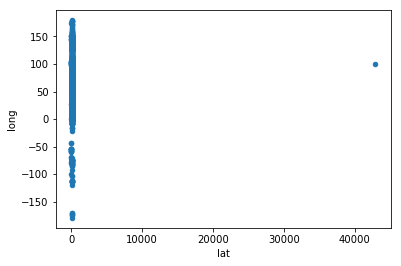

In [245]:
df[['lat', 'long']].plot.scatter(x='lat', y='long')

In [240]:
df = pd.DataFrame(final)
df.to_csv('data/map_objects.csv', encoding='utf8')
df.to_json('data/map_objects.json')

In [216]:
map_objects = requests.get(link_map_objects)
map_objects = map_objects.content
map_objects = json.loads(map_objects)

final = []
for current_object in tqdm_notebook(map_objects['features']):
    try:
        object_data = getMapObjectData(current_object)
        final.append(object_data)
        time.sleep(0.5)
    except Exception as e:
        print(e)                           # DEBUG
        print('problem',  current_object)  # DEBUG
        time.sleep(30)

KeyboardInterrupt: 

In [179]:
# if structures:
#     structures_data = []
#     structures = structures.findAll('h1')
#     for current_structure in structures:
#         current_structure_link = current_structure.find('a', href=True)['href']
#         current_structure_name = current_structure.getText().strip()
#         structures_data.append((current_structure_name, current_structure_link))